In [1]:
import cpuinfo
if "Intel" in cpuinfo.get_cpu_info()['brand_raw']:
    from sklearnex import patch_sklearn
    patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
os.chdir("..")

import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedGroupKFold, StratifiedKFold
from multiprocessing.dummy import Pool
import pandas as pd

from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor, LBPDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor

import matplotlib.pyplot as plt

from scipy.stats import truncnorm
import seaborn as sns

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Sampling Data (CHANGE TO USE ALL)

In [3]:
SAMPLE_SIZE = 50
root_path = Path().resolve()

chall1 = root_path/"data/processed/chall2/train"
mel_imgs = list((chall1/'mel').glob("*inpaint_0_5.png"))
bcc_imgs = list((chall1/'bcc').glob("*inpaint_0_5.png"))
scc_imgs = list((chall1/'scc').glob("*inpaint_0_5.png"))

test_imgs = np.concatenate([mel_imgs, bcc_imgs, scc_imgs])
# test_imgs = pd.read_pickle("test_imgs.pkl")

brisk = cv2.BRISK_create(thresh=30, octaves=0)


color_spaces = {'bgr':cv2.COLOR_RGB2BGR, 'hsv':cv2.COLOR_RGB2HSV, 'YCrCb':cv2.COLOR_RGB2YCrCb}
mshift_params = {'sp': 10, 'sr': 15} # spatial and color range radius


dense_brisk_color = ColorDescriptor(brisk, color_spaces, meanshift=mshift_params,
                                    min_keypoints=100, max_keypoints=500,
                                    kp_size=25)

dense_brick_texture = LBPDescriptor(brisk, min_keypoints=100, max_keypoints=500)

strf_split = StratifiedShuffleSplit(n_splits=5, random_state=42)


In [4]:
def BoW_cross_validation(descriptors, img_classes, n_splits=5, show_result=True):
    split_results = []
    for train_idxs, test_idxs in strf_split.split(descriptors, img_classes):
        split_result = {}
        X_train = [descriptors[i] for i in train_idxs]
        y_train = [img_classes[i] for i in train_idxs]
        X_test = [descriptors[i] for i in test_idxs]
        y_test = [img_classes[i] for i in test_idxs]
        
        
        bovw = BagofWords(n_words=100, n_jobs=-1, random_state=None)
        classifier = SVC(kernel='rbf', C=1, gamma=0.1, probability=True, class_weight='balanced')

        X_train_preprocessed = bovw.fit_transform(X_train,y_train) 
        X_test_preprocessed = bovw.transform(X_test)

        classifier.fit(X_train_preprocessed,y_train)
        y_pred = classifier.predict(X_test_preprocessed)

        split_result['y_test'] = y_test
        split_result['y_pred'] = y_pred
        split_result['accuracy'] = accuracy_score(y_test, y_pred)
        split_result['f1'] = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        split_result['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        split_result['classification_report'] = classification_report(y_test, y_pred, zero_division=0)
        
        split_results.append(split_result)
        
    if show_result:
        accs = [s['accuracy'] for s in split_results]
        f1s = [s['f1'] for s in split_results]

        print('Mean accuracy: ', np.mean(accs))
        print('Mean f1: ', np.mean(f1s))
        sns.boxplot(pd.DataFrame([accs, f1s], index=['accuracy', 'f1']).T)
        plt.show()
    return split_results

### Baseline BoW

##### Pure BoW of Texture - LBP

In [5]:
def _load_and_extract_des_texture(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2
    kpts, des = descriptor.detectAndCompute(im, mask)
    return (des, img_cls, image_path)

descriptors = []
img_classes = []
img_paths = []

with Pool(8) as pool:
    for (des, img_cls, ipath) in tqdm(pool.imap(_load_and_extract_des_texture,
                                       zip(test_imgs,
                                           [dense_brick_texture]*len(test_imgs))), total=len(test_imgs)):
        descriptors.append(des)
        img_classes.append(img_cls)
        img_paths.append(ipath)

100%|██████████| 5082/5082 [11:24<00:00,  7.42it/s]


Mean accuracy:  0.6640471512770137
Mean f1:  0.6310226290228493


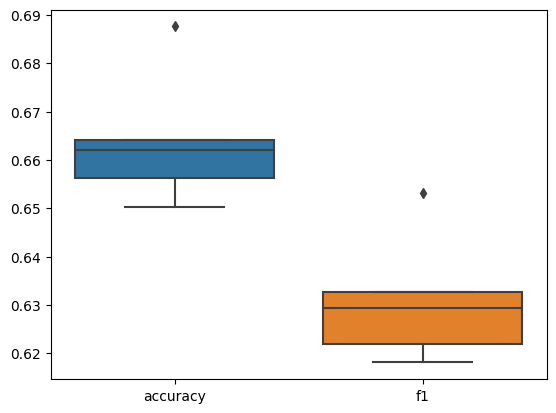

In [6]:
res_texture = BoW_cross_validation(descriptors, img_classes, n_splits=5, show_result=True)
pd.to_pickle((descriptors, img_classes, img_paths, res_texture), 'descriptors_texture.pkl')

##### Pure BoW of Color

In [7]:
def _load_and_extract_des(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path))
    mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2
    kpts, des = descriptor.detectAndCompute(im, mask)
    return (des, img_cls, image_path)

descriptors_color = []
img_classes_color = []
ipaths_color = []

with Pool(8) as pool:
    for (des, img_cls, ipath) in tqdm(pool.imap(_load_and_extract_des,
                                       zip(test_imgs,
                                           [dense_brisk_color]*len(test_imgs))), total=len(test_imgs)):
        descriptors_color.append(des)
        img_classes_color.append(img_cls)
        ipaths_color.append(ipath)

 32%|███▏      | 1633/5082 [29:19<1:04:00,  1.11s/it]/media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/skin_lesion_cad/features/colour.py:83: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(pixels),
/media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/skin_lesion_cad/features/colour.py:84: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(pixels),
/home/vzalevskyi/anaconda3/envs/cad/lib/python3.10/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
100%|██████████| 5082/5082 [1:23:34<00:00,  1.01it/s]  


Mean accuracy:  0.7214145383104126
Mean f1:  0.6933309259284373


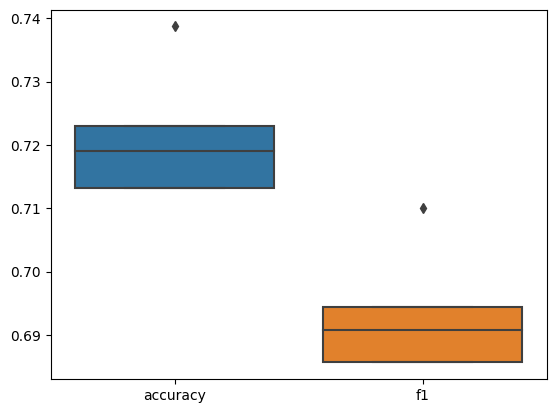

In [8]:
res_color = BoW_cross_validation(descriptors_color, img_classes_color, n_splits=5, show_result=True)
pd.to_pickle((descriptors_color, img_classes_color, ipaths_color, res_color), 'descriptors_color.pkl')

### For BoW try texture features (GLCM) extracting only from centered bbox

In [9]:
def _load_and_extract_des_texture(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    mask = np.zeros_like(im)
    # draw circle in the centre of the image
    mask = cv2.circle(mask, (im.shape[1]//2, im.shape[0]//2), 100, 255, -1)
    
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2
    kpts, des = descriptor.detectAndCompute(im, mask)
    return (des, img_cls, image_path)

descriptors = []
img_classes = []
img_paths = []

with Pool(8) as pool:
    for (des, img_cls, ipath) in tqdm(pool.imap(_load_and_extract_des_texture,
                                       zip(test_imgs,
                                           [dense_brick_texture]*len(test_imgs))), total=len(test_imgs)):
        descriptors.append(des)
        img_classes.append(img_cls)
        img_paths.append(ipath)

100%|██████████| 5082/5082 [10:03<00:00,  8.42it/s]


Mean accuracy:  0.6667976424361493
Mean f1:  0.6345669476871422


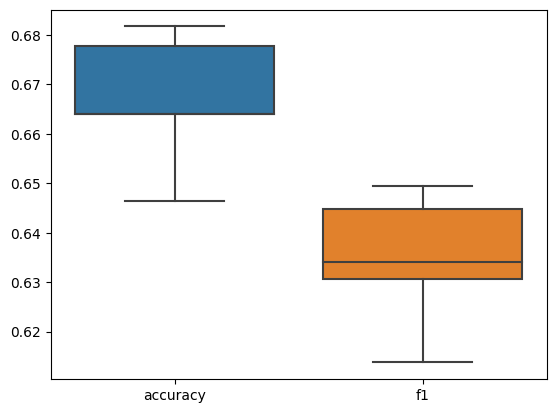

In [10]:
res_texture = BoW_cross_validation(descriptors, img_classes, n_splits=5, show_result=True)
pd.to_pickle((descriptors, img_classes, img_paths, res_texture), 'descriptors_texture_circle100.pkl')

In [11]:
def _load_and_extract_des(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path))
    mask = np.zeros_like(im)
    # draw circle in the centre of the image
    mask = cv2.circle(mask, (im.shape[1]//2, im.shape[0]//2), 100, 255, -1)
    
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2
    kpts, des = descriptor.detectAndCompute(im, mask)
    return (des, img_cls, image_path)

descriptors_color = []
img_classes_color = []
ipaths_color = []

with Pool(8) as pool:
    for (des, img_cls, ipath) in tqdm(pool.imap(_load_and_extract_des,
                                       zip(test_imgs,
                                           [dense_brisk_color]*len(test_imgs))), total=len(test_imgs)):
        descriptors_color.append(des)
        img_classes_color.append(img_cls)
        ipaths_color.append(ipath)

 26%|██▌       | 1314/5082 [23:10<45:31,  1.38it/s]  /media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/skin_lesion_cad/features/colour.py:83: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(pixels),
/media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/skin_lesion_cad/features/colour.py:84: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(pixels),
100%|██████████| 5082/5082 [1:24:41<00:00,  1.00it/s]  


Mean accuracy:  0.7292730844793713
Mean f1:  0.7019856597407699


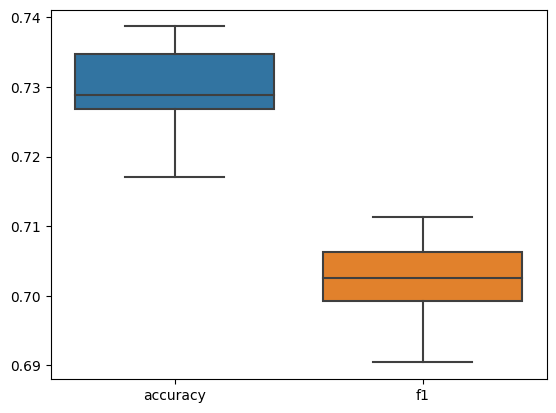

In [12]:
res_color = BoW_cross_validation(descriptors_color, img_classes_color, n_splits=5, show_result=True)
pd.to_pickle((descriptors_color, img_classes_color, ipaths_color, res_color), 'descriptors_color_circle100.pkl')

### Try sampling points for BoW using Gaussian with the mean on the image centre instead of uniform across the image

In [13]:
dense_brisk_color = ColorDescriptor(brisk, color_spaces, meanshift=mshift_params,
                              min_keypoints=100, max_keypoints=500,
                              kp_size=25, sample_method='gaussian')

dense_brick_texture = LBPDescriptor(brisk, min_keypoints=100, max_keypoints=500,
                                    sample_method='gaussian')

In [14]:
def _load_and_extract_des_texture(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    # mask = np.zeros_like(im)
    # draw circle in the centre of the image
    mask = None
    
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2
    kpts, des = descriptor.detectAndCompute(im, mask)
    return (des, img_cls, image_path)

descriptors = []
img_classes = []
img_paths = []

with Pool(8) as pool:
    for (des, img_cls, ipath) in tqdm(pool.imap(_load_and_extract_des_texture,
                                       zip(test_imgs,
                                           [dense_brick_texture]*len(test_imgs))), total=len(test_imgs)):
        descriptors.append(des)
        img_classes.append(img_cls)
        img_paths.append(ipath)

100%|██████████| 5082/5082 [10:14<00:00,  8.27it/s]


Mean accuracy:  0.6754420432220039
Mean f1:  0.6437440976654198


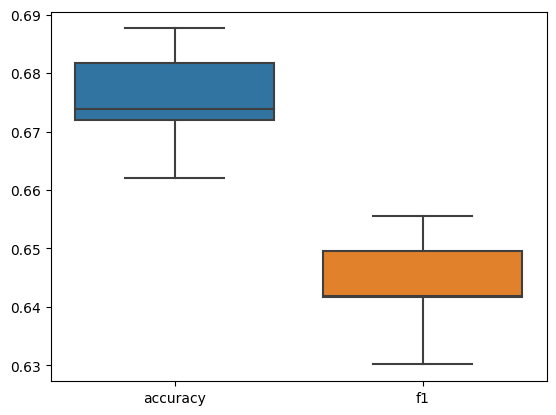

In [15]:
res_texture = BoW_cross_validation(descriptors, img_classes, n_splits=5, show_result=True)
pd.to_pickle((descriptors, img_classes, img_paths, res_texture), 'descriptors_texture_gauss.pkl')

In [16]:
def _load_and_extract_des(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path))
    
    mask = None
    
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2
    kpts, des = descriptor.detectAndCompute(im, mask)
    return (des, img_cls, image_path)

descriptors_color = []
img_classes_color = []
ipaths_color = []

with Pool(8) as pool:
    for (des, img_cls, ipath) in tqdm(pool.imap(_load_and_extract_des,
                                       zip(test_imgs,
                                           [dense_brisk_color]*len(test_imgs))), total=len(test_imgs)):
        descriptors_color.append(des)
        img_classes_color.append(img_cls)
        ipaths_color.append(ipath)

  4%|▎         | 188/5082 [03:56<2:40:44,  1.97s/it]/home/vzalevskyi/anaconda3/envs/cad/lib/python3.10/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/skin_lesion_cad/features/colour.py:83: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(pixels),
/media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/skin_lesion_cad/features/colour.py:84: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(pixels),
100%|██████████| 5082/5082 [1:25:40<00:00,  1.01s/it]  


Mean accuracy:  0.7335952848722986
Mean f1:  0.7054598047036531


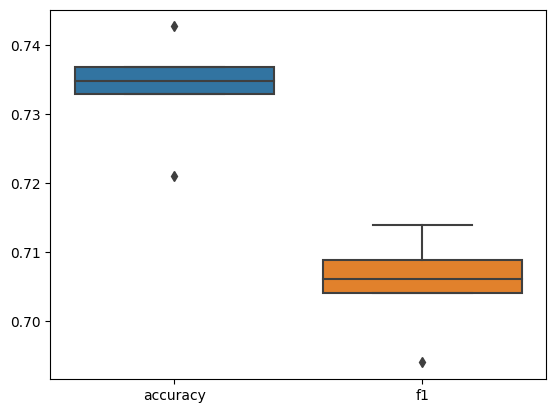

In [17]:
res_color = BoW_cross_validation(descriptors_color, img_classes_color, n_splits=5, show_result=True)
pd.to_pickle((descriptors_color, img_classes_color, ipaths_color, res_color), 'descriptors_color_gauss.pkl')

## 2. Fuse color and texture features (image wise, no BoW)
    - Probability fusion
    - Feature fusion

In [18]:
from skin_lesion_cad.features.texture import  get_glcm

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, f1_score
from sklearn import preprocessing
from sklearn.utils import resample, shuffle
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline

In [19]:
glcm_f = get_glcm(np.unique(test_imgs))
glcm_f['class'] = glcm_f['image_0'].apply(lambda x: x.split('/')[-1][:3]).values
glcm_f['class'] = glcm_f['class'].replace({'bcc': 0, 'mel': 1, 'scc': 2})
glcm_f['name'] = glcm_f['image_0'].apply(lambda x: x.split('/')[-1].split('_')[0]).values
glcm_f = glcm_f.set_index('name')

100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


### Pure GLCM features 

In [20]:
text_X = glcm_f.drop(columns=['image_0', 'class'])
text_y = glcm_f['class'].values

In [21]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', class_weight='balanced'))])

Mean f1 score: 0.6446283965105291
{'fit_time': array([0.84287429, 0.7248888 , 0.9257369 , 0.77079892, 0.92784286]), 'score_time': array([0.02459121, 0.02977991, 0.01263928, 0.02016687, 0.01688766]), 'test_f1_weighted': array([0.64959426, 0.64444561, 0.63151137, 0.64120198, 0.65638876]), 'train_f1_weighted': array([0.65248226, 0.65811975, 0.65895157, 0.65126963, 0.65008521])}


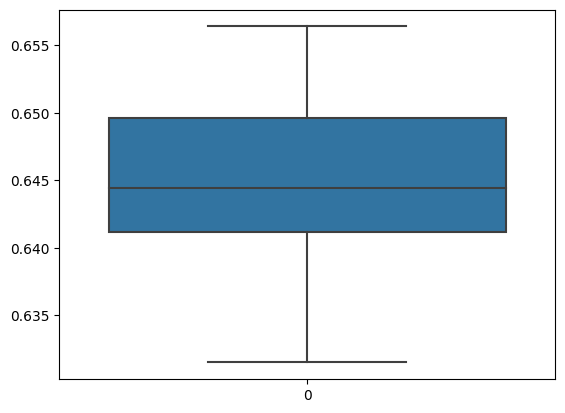

In [22]:
texture_scores = cross_validate(pipe,
                                text_X, text_y,
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                scoring=['f1_weighted'], n_jobs=-1,
                                return_estimator=False,
                                return_train_score=True)

sns.boxplot(texture_scores['test_f1_weighted'])
print('Mean f1 score:', np.mean(texture_scores['test_f1_weighted']))
print(texture_scores)

### Pure color features

In [23]:
proc_data = Path().resolve() / 'data/processed'
chl = 'chall2'
mode = 'train'
feat_type = 'raw'


test_path = proc_data / f'{chl}/{mode}'
print('\nAnalyzing features for', feat_type)

bcc_data = pd.read_feather(test_path / f'bcc_color_features_{feat_type}_full_image.feather').set_index('name')
bcc_data['class'] = 0

mel_data = pd.read_feather(test_path/ f'mel_color_features_{feat_type}_full_image.feather').set_index('name')
mel_data['class'] = 1

scc_data = pd.read_feather(test_path/ f'scc_color_features_{feat_type}_full_image.feather').set_index('name')
scc_data['class'] = 2

data = pd.concat([scc_data, bcc_data, mel_data])

current_test_data = data.loc[[str(x.name).split('_')[0] for x in np.unique(test_imgs)]]
current_test_data


Analyzing features for raw


,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,YCrCb_C_unq,YCrCb_r_mean,YCrCb_r_std,YCrCb_r_skew,YCrCb_r_kurt,YCrCb_r_max,YCrCb_r_min,YCrCb_r_entrp,YCrCb_r_unq,class
name,,,,,,,,,,,,,,,,,,,,,
bcc00001,173.945435,10.597287,-2.697558,11.596371,206.0,84.0,12.474669,123,153.459549,16.038431,...,3969,11.583411,6.117791,0.301657,-0.417882,34.298828,-8.675714,-inf,3969,0
bcc00002,35.787140,53.451935,0.976201,-0.871779,145.0,0.0,11.355463,146,33.906147,51.502922,...,5717,0.823033,3.209846,2.457493,16.213585,28.839308,-14.509736,-inf,5700,0
bcc00003,162.768723,10.034433,-2.130192,6.014011,183.0,96.0,12.474655,85,103.532433,15.076412,...,3571,32.141727,3.426851,0.593374,0.534732,50.151745,17.845823,12.471048,3263,0
bcc00004,68.577240,99.770226,0.857715,-1.203371,238.0,0.0,11.392195,239,52.333580,76.564606,...,6836,9.414767,13.684149,1.125763,-0.272595,59.851978,-0.499408,-inf,6834,0
bcc00005,122.940521,100.063133,-0.249532,-1.865982,230.0,0.0,12.021663,231,118.051697,96.469452,...,3925,3.399568,5.604658,1.715246,2.540194,30.301199,-8.344652,-inf,3925,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00372,173.701965,46.859707,-2.214540,5.005815,227.0,0.0,12.421574,228,115.816170,36.996120,...,5618,28.467009,8.854438,-0.816060,2.677067,57.135189,-0.499408,-inf,5617,2
scc00373,105.880669,82.956131,-0.295667,-1.746753,206.0,0.0,12.041123,207,94.817429,73.815422,...,5623,5.140180,6.829775,0.993957,0.190351,32.081745,-12.916433,-inf,5622,2
scc00374,187.460068,14.803250,-1.434498,2.456302,212.0,90.0,11.116625,113,159.424210,26.224405,...,2896,13.974027,6.754467,1.047934,0.340478,37.478092,3.473410,11.012215,2896,2


In [24]:
all_X = current_test_data.drop(columns=['class']).values
all_y = current_test_data['class'].values


all_X[np.isnan(all_X)] = 0
all_X[np.isinf(all_X)] = 0

Mean f1 score: 0.7721050084485447
{'fit_time': array([0.28086305, 0.52313876, 0.57607579, 0.58146191, 0.33014584]), 'score_time': array([0.01058531, 0.03139186, 0.03384972, 0.03307915, 0.01400208]), 'test_f1_weighted': array([0.76631605, 0.76348652, 0.75732836, 0.79408834, 0.77930576]), 'train_f1_weighted': array([0.80255765, 0.80580143, 0.80931873, 0.80342571, 0.80670456])}


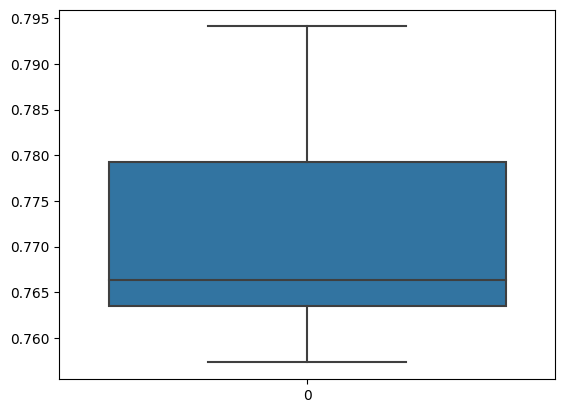

In [25]:
color_scores = cross_validate(pipe,
                                all_X, all_y,
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                scoring=['f1_weighted'], n_jobs=-1,
                                return_estimator=False,
                                return_train_score=True)

sns.boxplot(color_scores['test_f1_weighted'])
print('Mean f1 score:', np.mean(color_scores['test_f1_weighted']))
print(color_scores)

### Probability fusion

In [26]:
# res = {'f1_wieghted':[], 'accuracy':[], 'confusion_matrix':[]}

# for train_idxs, test_indexes in StratifiedShuffleSplit(n_splits=5, random_state=42).split(all_X, all_y):

#     batch_res = {}
#     # test_indexes = np.random.choice((current_test_data.index.values), size=20, replace=False)

#     train_glcm = glcm_f.iloc[train_idxs].sample(frac=1)
#     test_glcm = glcm_f.iloc[test_indexes]

#     train_color = current_test_data.iloc[train_idxs].sample(frac=1)
#     test_color = current_test_data.iloc[test_indexes]

#     X_train_color = train_color.drop(columns=[ 'class']).values
#     y_train_color = train_color['class'].values

#     X_test_color = test_color.drop(columns=['class']).values
#     y_test_color = test_color['class'].values


#     X_train_color[np.isnan(X_train_color)] = 0
#     X_train_color[np.isinf(X_train_color)] = 0
#     X_test_color[np.isnan(X_test_color)] = 0
#     X_test_color[np.isinf(X_test_color)] = 0

#     scaler_color = StandardScaler()
#     X_train_color = scaler_color.fit_transform(X_train_color)
#     X_test_color = scaler_color.transform(X_test_color)

#     svc_color = SVC(kernel='rbf', probability=True)
#     svc_color.fit(X_train_color, y_train_color)

#     y_test_color_pred = svc_color.predict_proba(X_test_color)
#     y_train_color_pred = svc_color.predict_proba(X_train_color)
    
    
#     svc_glcm = SVC(kernel='rbf', probability=True)
#     svc_glcm.fit(X_train, y_train_color)
    
#     y_train_glcm_pred = svc_glcm.predict_proba(X_train_color)
#     y_test_glcm_pred = svc_glcm.predict_proba(X_test_color)
    
#     train = np.hstack([y_train_color_pred, y_train_glcm_pred])
#     test = np.hstack([y_test_color_pred, y_test_glcm_pred])

#     svc_fused = SVC(kernel='rbf', probability=True)
#     svc_fused.fit(train, y_train_color)

#     y_test_fused = svc_fused.predict(test)
    
#     res['f1_wieghted'] = f1_score(y_test_color, y_test_fused, average='weighted')
#     res['accuracy'] = accuracy_score(y_test_color, y_test_fused)
#     res['confusion_matrix'] = confusion_matrix(y_test_color, y_test_fused)

### Feature fusions

In [27]:
merged_data = glcm_f.join(current_test_data.drop(columns=['class']), how='inner')

all_X = merged_data.drop(columns=['class', 'image_0']).values
all_y = merged_data['class'].values

merged_data.drop(columns=['class', 'image_0']).sample()

,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,dissimilarity_0,dissimilarity_1,...,YCrCb_C_entrp,YCrCb_C_unq,YCrCb_r_mean,YCrCb_r_std,YCrCb_r_skew,YCrCb_r_kurt,YCrCb_r_max,YCrCb_r_min,YCrCb_r_entrp,YCrCb_r_unq
name,,,,,,,,,,,,,,,,,,,,,
bcc01191,12.950881,7.712145,12.407606,7.576227,52.207463,62.736933,51.706492,65.52938,2.450712,1.844321,...,-inf,3825,5.521041,6.281279,0.84437,0.188058,37.946777,-8.344652,-inf,3825


Mean f1 score: 0.7712372551526357
{'fit_time': array([0.80330849, 0.67357135, 0.21521568, 0.69166875, 0.74010324]), 'score_time': array([0.05298805, 0.02293444, 0.00888586, 0.03230834, 0.05815196]), 'test_f1_weighted': array([0.77044127, 0.75894097, 0.75909016, 0.78401212, 0.78370175]), 'train_f1_weighted': array([0.80820386, 0.80509954, 0.81362342, 0.80476557, 0.81084161])}


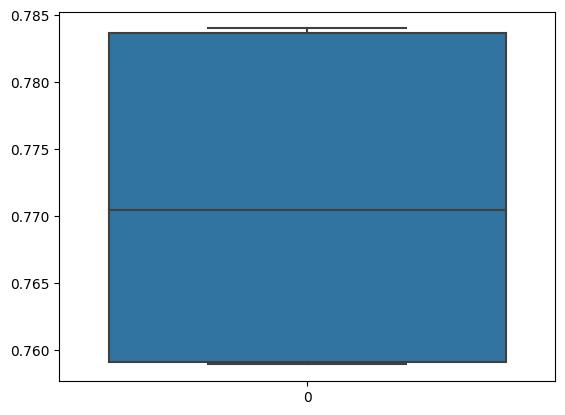

In [28]:
all_X[np.isnan(all_X)] = 0
all_X[np.isinf(all_X)] = 0

color_scores = cross_validate(pipe,
                                all_X, all_y,
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                scoring=['f1_weighted'], n_jobs=-1,
                                return_estimator=False,
                                return_train_score=True)

sns.boxplot(color_scores['test_f1_weighted'])
print('Mean f1 score:', np.mean(color_scores['test_f1_weighted']))
print(color_scores)